<div class="alert alert-block alert-dark">

## <center> Group Project - ABCDEATS Customer Segmentation </center> <br>
#  <center> <b> Density-Based Spatial Clustering of Applications with Noise </center> <br>
#  <center> <b> Gaussian Mixture Model Clustering </center> <br>
## <center> Master Data Science and Advanced Analytics <center>
## <center> Fall Semester 2024-2025 <center>
<br>
<center> Group 36: <center> <br>
<center>Eduardo Mendes, 20240850  <br><center>
<center>Joana Esteves, 20240746 <br><center>
<center>João Afonso Freire, 20240528 <br><center>
<center>Tomás Figueiredo, 20240941  <br><center>

<div>

**Table of Contents:**

- [1. Perform DBSCAN Clustering](#dbscan)

  - [1.1. Import the needed Libraries](#importlibraries)

  - [1.2. Import Dataset](#importdataset)

  - [1.3. K-distance Graph for Determining Epsilon (eps)](#kdistance)


  - [1.4. Perform DBSCAN Clustering](#dbscanperform)

    - [1.4.1. Cluster Visualization](#dbscanvisualization)

    - [1.4.2. Noise Detection and Evaluation](#dbscannoise)

  - [1.5. Save Results ](#savedbscan)   

- [2. Perform Gaussian Mixture Model (GMM) Clustering](#gmm)

  - [2.1. Optimal Number of Clusters Using Silhouette Score](#gmmsilhouette)

  - [2.2. Visualize GMM Clusters](#gmmvisualization)

  - [2.3. Save the Results](#savegmm)


<a class="anchor" id="dbscan">

# **1. Perform DBSCAN Clustering**

</a>

<a class="anchor" id="importlibraries">

## 1.1. Import the needed Libraries

</a>

In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

<a class="anchor" id="importlibraries">

## 1.2. Import Dataset

</a>

In [3]:
# Load the preprocessed dataset
data = pd.read_parquet('Data_Preprocessed.parquet')
data = data.select_dtypes(include=['float64', 'int64'])  # Keep only numerical columns

In [44]:
data.columns

Index(['customer_age', 'vendor_count', 'product_count', 'is_chain',
       'first_order', 'last_order', 'CUI_American', 'CUI_Asian',
       'CUI_Beverages', 'CUI_Cafe', 'CUI_Chicken Dishes', 'CUI_Chinese',
       'CUI_Desserts', 'CUI_Healthy', 'CUI_Indian', 'CUI_Italian',
       'CUI_Japanese', 'CUI_Noodle Dishes', 'CUI_OTHER',
       'CUI_Street Food / Snacks', 'CUI_Thai', 'weekend_orders',
       'weekdays_orders', 'total_orders', 'proportion_weekend',
       'proportion_weekdays', 'breakfast', 'lunch', 'snack', 'dinner',
       'late_night', 'proportion_breakfast', 'proportion_lunch',
       'proportion_snack', 'proportion_dinner', 'proportion_late_night',
       'total_spent', 'avg_spent_per_order', 'avg_products_per_order',
       'avg_price_per_product', 'recency', 'active_period', 'order_frequency',
       'cuisine_diversity', 'vendor_loyalty'],
      dtype='object')

In [4]:
# Select specific features for clustering
segmentation_features = ["total_orders", 'avg_spent_per_order',
                         'vendor_loyalty', "order_frequency"]
data = data[segmentation_features]

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30211 entries, 1b8f824d5e to fd40d3b0e0
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   total_orders         30211 non-null  float64
 1   avg_spent_per_order  30211 non-null  float64
 2   vendor_loyalty       30211 non-null  float64
 3   order_frequency      30211 non-null  float64
dtypes: float64(4)
memory usage: 1.2+ MB


<a class="anchor" id="kdistance">

# 1.3. K-distance Graph for Determining Epsilon (eps)

</a>

In [47]:
# Calculate k-distance to find the optimal eps value
min_samples = 2 * data.shape[1]  # Rule of thumb: min_samples = 2 x dimensions
neigh = NearestNeighbors(n_neighbors=min_samples)
neigh.fit(data)
distances, _ = neigh.kneighbors(data)

# Sort distances for the k-th nearest neighbor
distances = np.sort(distances[:, -1])

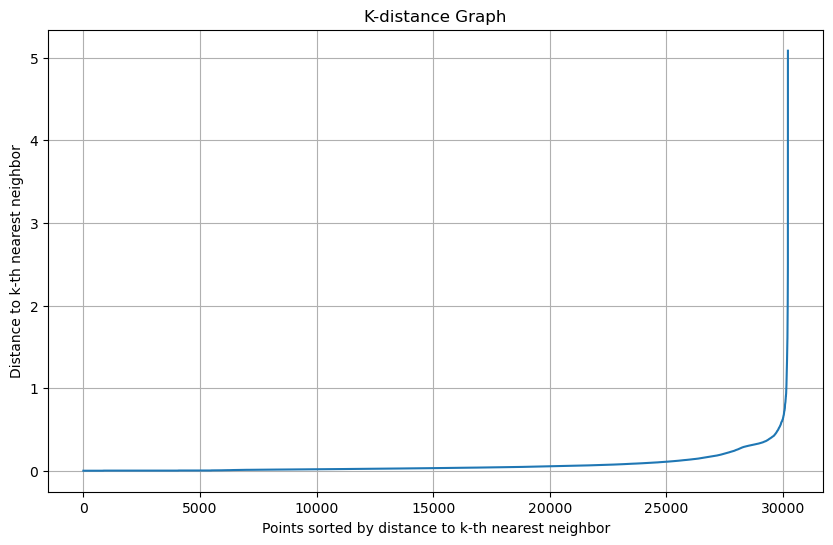

In [48]:
# Plot the k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('K-distance Graph')
plt.xlabel('Points sorted by distance to k-th nearest neighbor')
plt.ylabel('Distance to k-th nearest neighbor')
plt.grid()
plt.show()

<a class="anchor" id="dbscan">

# 1.4. Perform DBSCAN Clustering

</a>

In [49]:
# Set DBSCAN parameters (eps determined from k-distance graph)
dbscan = DBSCAN(eps=0.8, min_samples=min_samples, n_jobs=-1)
clusters = dbscan.fit_predict(data)
data['Cluster'] = clusters # Add cluster labels to the dataset

In [50]:
# Print the number of clusters and their distribution
unique_clusters = np.unique(clusters)
print(f"Number of clusters (including noise): {len(unique_clusters)}")
print("Cluster distribution:")
print(data['Cluster'].value_counts())

Number of clusters (including noise): 6
Cluster distribution:
Cluster
 0    29852
 1      199
 3       71
-1       64
 4       13
 2       12
Name: count, dtype: int64


<a class="anchor" id="dbscanvisualization">

### 1.4.1. Cluster Visualization

</a>

In [51]:
# Reduce data to 2 dimensions using PCA
pca = PCA(n_components=2)
data_reduced = pca.fit_transform(data.drop(columns=['Cluster']))  # Excluímos a coluna 'Cluster' antes de aplicar o PCA

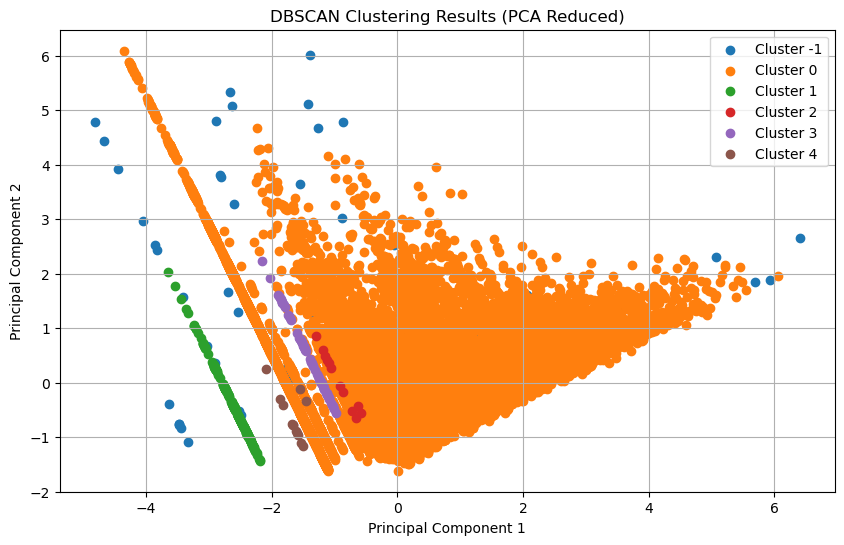

In [52]:
# Plot the clusters
plt.figure(figsize=(10, 6))
for cluster in unique_clusters:
    cluster_points = data_reduced[data['Cluster'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}")
plt.title("DBSCAN Clustering Results (PCA Reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid()
plt.show()

<a class="anchor" id="dbscannoise">

### 1.4.2. Noise Detection and Evaluation

</a>

In [53]:
# Identify points labeled as noise (Cluster = -1)
outliers = data.loc[data['Cluster'] == -1]
print(f"Number of outliers (noise points): {len(outliers)}")

Number of outliers (noise points): 64


In [54]:
# Exclude noise points for R² calculation
#data_nonoise = data.loc[data['Cluster'] != -1]
#data_nonoise_values = data_values[data['Cluster'] != -1]

In [55]:
# Compute Silhouette Score
silhouette_avg = silhouette_score(data, clusters)
print(f"Silhouette Score: {silhouette_avg:.4f}")

Silhouette Score: 0.3576


<a class="anchor" id="savedbscan">

## 1.5. Save the Results

</a>

In [56]:
# Save the dataset with cluster labels to a new CSV file
data.to_csv('Data_DBSCAN_with_Clusters.csv', index=False)
print("Cluster labels added and saved to 'Data_DBSCAN_with_Clusters.csv'.")

Cluster labels added and saved to 'Data_DBSCAN_with_Clusters.csv'.


<a class="anchor" id="gmm">

# **2. Perform Gaussian Mixture Model (GMM) Clustering**

</a>

<a class="anchor" id="gmmsilhouette">

## 2.1. Optimal Number of Clusters Using Silhouette Score

</a>

## Load and Prepare the Dataset

In [17]:
# Step 1: Load the preprocessed dataset
data = pd.read_parquet('Data_Preprocessed.parquet')
data = data.select_dtypes(include=['float64', 'int64'])  # Keep only numerical columns

In [18]:
# Step 2: Select specific features for clustering
segmentation_features = ["active_period", "vendor_count",
                         "product_count", 'cuisine_diversity']
data = data[segmentation_features]

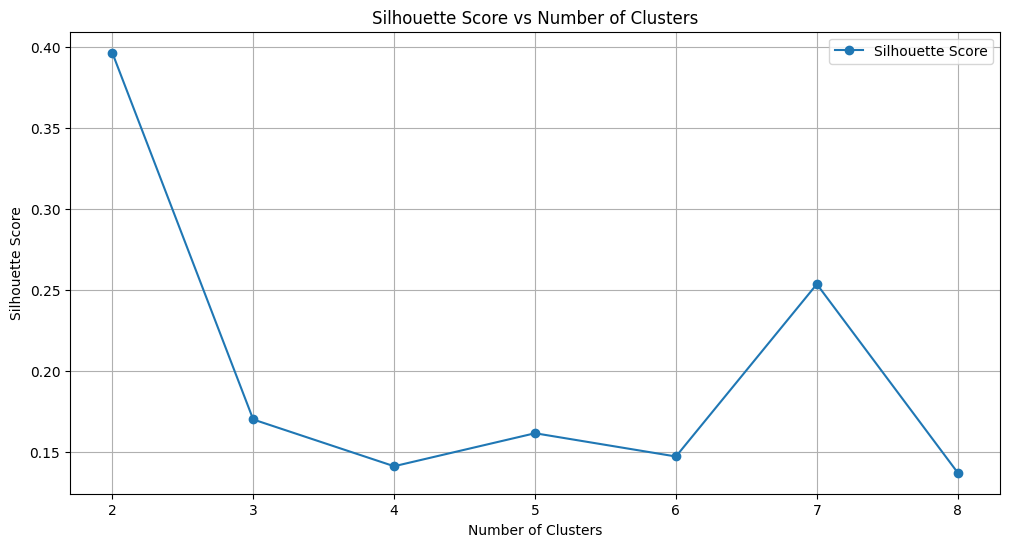

In [19]:
# Define the range of clusters to test
cluster_range = range(2, 9)  # Test from 2 to 8 clusters
silhouette_scores = []

# Iterate over the range of clusters
for n_clusters in cluster_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm_labels = gmm.fit_predict(data)

    # Compute Silhouette Score
    silhouette_avg = silhouette_score(data, gmm_labels)
    silhouette_scores.append(silhouette_avg)

# Plot Silhouette Scores
plt.figure(figsize=(12, 6))
plt.plot(cluster_range, silhouette_scores, marker='o', label='Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid()
plt.show()

In [20]:
# Best number of clusters based on Silhouette Score
best_n_clusters = cluster_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters (Silhouette): {best_n_clusters}")

Optimal number of clusters (Silhouette): 2


<a class="anchor" id="gmmvisualization">

## 2.2. Visualize GMM Clusters

</a>

In [21]:
# Fit the GMM model
gmm = GaussianMixture(n_components=best_n_clusters, random_state=42)
gmm_labels = gmm.fit_predict(data)

In [22]:
# Add cluster labels to the dataset
data['Cluster'] = gmm_labels

In [23]:
# Reduce data to 2 dimensions for visualization
pca = PCA(n_components=2)
data_reduced = pca.fit_transform(data)

In [24]:
# Print the cluster distribution
print("Cluster distribution:")
print(data['Cluster'].value_counts())

Cluster distribution:
Cluster
1    19557
0    10654
Name: count, dtype: int64


Cluster distribution with 7 clusters:

- 3:    6884
- 4:    6435
- 5:    4586
- 0:    4407
- 2:    4120
- 1:    2638
- 6:    1141

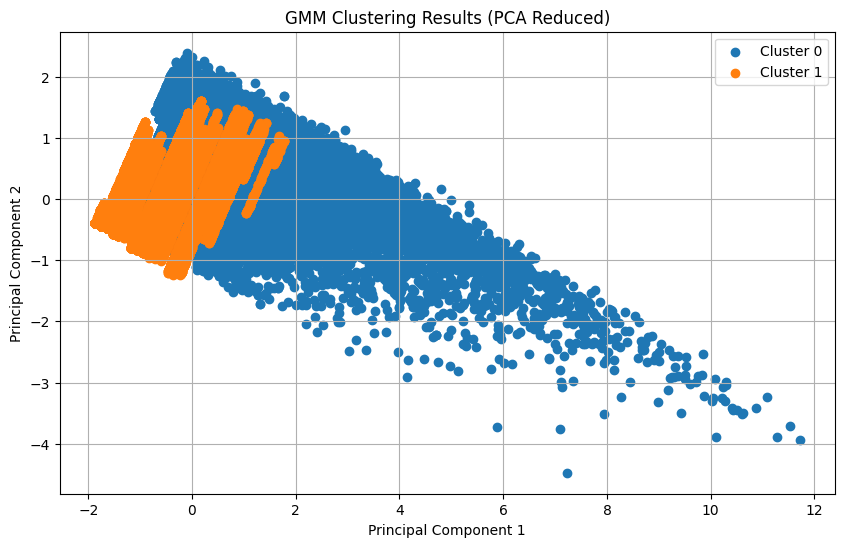

In [25]:
# Plot the clusters in 2D
plt.figure(figsize=(10, 6))
unique_clusters = np.unique(gmm_labels)
for cluster in unique_clusters:
    cluster_points = data_reduced[gmm_labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}")
plt.title("GMM Clustering Results (PCA Reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid()
plt.show()

<a class="anchor" id="savegmm">

# **2.3. Save the Results**

</a>

In [26]:
# Save the dataset with GMM cluster labels to a new CSV file
data.to_csv('Data_GMM_Clusters.csv', index=False)
print("Cluster labels added and saved to 'Data_GMM_Clusters.csv'.")

Cluster labels added and saved to 'Data_GMM_Clusters.csv'.
